# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Импортируем библиотеки 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

### Шаг.  Откройте файл с данными и изучите общую информацию

Путь к файлам:

/datasets/calls.csv. Скачать датасет

/datasets/internet.csv. Скачать датасет

/datasets/messages.csv. Скачать датасет

/datasets/tariffs.csv. Скачать датасет

/datasets/users.csv. Скачать датасет

In [2]:
calls_data = pd.read_csv('/datasets/calls.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
messages_data = pd.read_csv('/datasets/messages.csv')
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv')

calls_data.info()
display(calls_data.head())
print()
internet_data.info()
display(internet_data.head())
print()
messages_data.info()
display(messages_data.head())
print()
tariffs_data.info()
display(tariffs_data.head())
print()
users_data.info()
users_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Вывод:
- Обнаружен неверный формат даты во всех таблицах с датами
- Необходимо округлить время звонков и мегабайты трафика в большую сторону в соответствии с условиями тарифов

### Шаг. Подготовьте данные

#### Приведем даты к формату datetime

In [3]:
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')


In [4]:
users_data.info()
display(users_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### добавляем столбец month

In [5]:
calls_data['month'] = pd.DatetimeIndex(calls_data['call_date']).month
internet_data['month'] = pd.DatetimeIndex(internet_data['session_date']).month
messages_data['month'] = pd.DatetimeIndex(messages_data['message_date']).month
internet_data

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,10
149392,149392,1499_153,490.13,2018-12-14,1499,12
149393,149393,1499_154,0.00,2018-10-27,1499,10
149394,149394,1499_155,1246.32,2018-11-26,1499,11


#### округлим в большую сторону звонки

In [6]:
calls_data['duration'] = calls_data['duration'].apply(np.ceil)
display(calls_data)
pivot_calls_data = calls_data.pivot_table(index = ['month', 'user_id'], values = 'duration', aggfunc = ('sum', 'count'))
pivot_calls_data = pivot_calls_data.rename(columns = {'count' : 'count_call', 'sum' : 'duration_call'})
display(pivot_calls_data)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


count_call  duration_call
month user_id                           
1     1005             15           95.0
      1032             61          380.0
      1045              1            9.0
      1055             64          551.0
      1071             24          194.0
...                   ...            ...
12    1494             62          418.0
      1495            155         1031.0
      1496             80          518.0
      1497             71          545.0
      1499             69          492.0

[3174 rows x 2 columns]

#### округлим в большую сторону интернет трафик

In [7]:
pivot_internet_data = internet_data.pivot_table(index = ['month', 'user_id'], values = 'mb_used', aggfunc = ('sum', 'count'))
pivot_internet_data['gb_used'] = np.ceil(pivot_internet_data['sum']/1024)
pivot_internet_data = pivot_internet_data.rename(columns = {'count' : 'count_session', 'sum' : 'mb_used'})
display(pivot_internet_data)

count_session   mb_used  gb_used
month user_id                                  
1     1005                 6   2727.97      3.0
      1032                62  24127.69     24.0
      1045                 5   2346.71      3.0
      1055                47  17090.88     17.0
      1071                40  15604.34     16.0
...                      ...       ...      ...
12    1494                49  17621.21     18.0
      1495                47  23426.76     23.0
      1496                68  20736.15     21.0
      1497                47  19918.60     20.0
      1499                45  13055.58     13.0

[3203 rows x 3 columns]

#### посчитаем отправленные сообщения

In [8]:
pivot_messages_data = messages_data.pivot_table(index = ['month', 'user_id'], values = 'id', aggfunc = 'count')
pivot_messages_data = pivot_messages_data.rename(columns = {'id' : 'count_messages'})
display(pivot_messages_data)

count_messages
month user_id                
1     1005                  7
      1032                 38
      1045                  5
      1055                 30
      1071                 16
...                       ...
12    1493                 78
      1495                 84
      1496                 51
      1497                 17
      1499                 66

[2717 rows x 1 columns]

#### создадим ключ

In [9]:
key_data = calls_data.append(internet_data, sort=False)
key_data = key_data.append(messages_data, sort=False)
key_data = key_data.pivot_table(index = ['month', 'user_id'], values = 'id', aggfunc = 'count')
key_data = key_data.drop(["id"], axis=1)
key_data

Empty DataFrame
Columns: []
Index: [(1, 1005), (1, 1032), (1, 1045), (1, 1055), (1, 1071), (1, 1113), (1, 1120), (1, 1126), (1, 1134), (1, 1135), (1, 1155), (1, 1168), (1, 1176), (1, 1189), (1, 1193), (1, 1204), (1, 1219), (1, 1227), (1, 1238), (1, 1254), (1, 1282), (1, 1299), (1, 1302), (1, 1308), (1, 1337), (1, 1340), (1, 1372), (1, 1373), (1, 1375), (1, 1378), (1, 1381), (1, 1385), (1, 1394), (1, 1395), (1, 1396), (1, 1401), (1, 1423), (1, 1429), (1, 1433), (1, 1453), (1, 1472), (1, 1475), (1, 1496), (2, 1005), (2, 1006), (2, 1032), (2, 1045), (2, 1055), (2, 1071), (2, 1072), (2, 1089), (2, 1104), (2, 1109), (2, 1113), (2, 1120), (2, 1126), (2, 1134), (2, 1135), (2, 1152), (2, 1155), (2, 1157), (2, 1158), (2, 1168), (2, 1174), (2, 1176), (2, 1180), (2, 1186), (2, 1188), (2, 1189), (2, 1193), (2, 1204), (2, 1217), (2, 1219), (2, 1227), (2, 1238), (2, 1240), (2, 1251), (2, 1254), (2, 1255), (2, 1277), (2, 1282), (2, 1285), (2, 1291), (2, 1292), (2, 1294), (2, 1299), (2, 1302), (2, 1308), (2, 1321), (2, 1330), (2, 1337), (2, 1340), (2, 1358), (2, 1370), (2, 1372), (2, 1373), (2, 1375), (2, 1377), (2, 1378), (2, 1381), ...]

[3214 rows x 0 columns]

#### обьединение сводных таблиц

In [10]:
total_data = key_data.merge(pivot_calls_data, on=['user_id', 'month'], how='left')
total_data = total_data.merge(pivot_internet_data, on=['user_id', 'month'], how='left').drop(["mb_used"], axis=1)
total_data = total_data.merge(pivot_messages_data, on=['user_id', 'month'], how='left')
total_data.info()
total_data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1005, 1) to (1499, 12)
Data columns (total 5 columns):
count_call        3174 non-null float64
duration_call     3174 non-null float64
count_session     3203 non-null float64
gb_used           3203 non-null float64
count_messages    2717 non-null float64
dtypes: float64(5)
memory usage: 139.1 KB


,,count_call,duration_call,count_session,gb_used,count_messages
user_id,month,,,,,
1005,1,15.0,95.0,6.0,3.0,7.0
1032,1,61.0,380.0,62.0,24.0,38.0
1045,1,1.0,9.0,5.0,3.0,5.0
1055,1,64.0,551.0,47.0,17.0,30.0
1071,1,24.0,194.0,40.0,16.0,16.0
...,...,...,...,...,...,...
1494,12,62.0,418.0,49.0,18.0,NaN
1495,12,155.0,1031.0,47.0,23.0,84.0
1496,12,80.0,518.0,68.0,21.0,51.0


#### добавим в таблицу название тарифа и город пользователя

In [11]:
total_data = total_data.merge(users_data[['user_id', 'city', 'tariff']], on='user_id', how='left')
total_data.info()
total_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id           3214 non-null int64
count_call        3174 non-null float64
duration_call     3174 non-null float64
count_session     3203 non-null float64
gb_used           3203 non-null float64
count_messages    2717 non-null float64
city              3214 non-null object
tariff            3214 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 226.0+ KB


,user_id,count_call,duration_call,count_session,gb_used,count_messages,city,tariff
0,1005,15.0,95.0,6.0,3.0,7.0,Набережные Челны,smart
1,1032,61.0,380.0,62.0,24.0,38.0,Ульяновск,smart
2,1045,1.0,9.0,5.0,3.0,5.0,Улан-Удэ,smart
3,1055,64.0,551.0,47.0,17.0,30.0,Казань,smart
4,1071,24.0,194.0,40.0,16.0,16.0,Омск,smart
...,...,...,...,...,...,...,...,...
3209,1494,62.0,418.0,49.0,18.0,NaN,Омск,smart
3210,1495,155.0,1031.0,47.0,23.0,84.0,Иркутск,ultra
3211,1496,80.0,518.0,68.0,21.0,51.0,Вологда,smart
3212,1497,71.0,545.0,47.0,20.0,17.0,Челябинск,smart


In [12]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### посчитаем ежемесячные платежи пользователей, для этого сначало создадим функцию 

In [13]:
def price_formula(row):
    if row['tariff'] == 'smart':
        if row['duration_call'] > 500:
            bill_for_calls = (row['duration_call'] - 500) * 3     
        else:
            bill_for_calls = 0
            
        if row['count_messages'] > 50:
            bill_for_messages = (row['count_messages'] - 50) * 3
        else:
            bill_for_messages = 0
            
        if row['gb_used'] > 15:
            bill_for_gb = (row['gb_used'] - 15) * 200
        else:
            bill_for_gb = 0
            
        total_cost = bill_for_calls + bill_for_messages + bill_for_gb + 550
        
    elif row['tariff'] == 'ultra':
        if row['duration_call'] > 3000:
            bill_for_calls = (row['duration_call'] - 3000) * 1    
        else:
            bill_for_calls = 0
            
        if row['count_messages'] > 1000:
            bill_for_messages = (row['count_messages'] - 1000) * 1
        else:
            bill_for_messages = 0
            
        if row['gb_used'] > (30720 / 1024):
            bill_for_gb = (row['gb_used'] - (30720 / 1024)) * 150
        else:
            bill_for_gb = 0
        
        total_cost = bill_for_calls + bill_for_messages + bill_for_gb + 1950
        
    return total_cost

In [14]:
total_data['total_cost'] = total_data.apply(price_formula, axis=1)
total_data.info()
total_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
user_id           3214 non-null int64
count_call        3174 non-null float64
duration_call     3174 non-null float64
count_session     3203 non-null float64
gb_used           3203 non-null float64
count_messages    2717 non-null float64
city              3214 non-null object
tariff            3214 non-null object
total_cost        3214 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 251.1+ KB


,user_id,count_call,duration_call,count_session,gb_used,count_messages,city,tariff,total_cost
0,1005,15.0,95.0,6.0,3.0,7.0,Набережные Челны,smart,550.0
1,1032,61.0,380.0,62.0,24.0,38.0,Ульяновск,smart,2350.0
2,1045,1.0,9.0,5.0,3.0,5.0,Улан-Удэ,smart,550.0
3,1055,64.0,551.0,47.0,17.0,30.0,Казань,smart,1103.0
4,1071,24.0,194.0,40.0,16.0,16.0,Омск,smart,750.0
...,...,...,...,...,...,...,...,...,...
3209,1494,62.0,418.0,49.0,18.0,NaN,Омск,smart,1150.0
3210,1495,155.0,1031.0,47.0,23.0,84.0,Иркутск,ultra,1950.0
3211,1496,80.0,518.0,68.0,21.0,51.0,Вологда,smart,1807.0
3212,1497,71.0,545.0,47.0,20.0,17.0,Челябинск,smart,1685.0



#### Заполним пропущенные значения


In [15]:
total_data['count_call'] = total_data['count_call'].fillna(0)
total_data['duration_call'] = total_data['duration_call'].fillna(0)
total_data['count_session'] = total_data['count_session'].fillna(0)
total_data['gb_used'] = total_data['gb_used'].fillna(0)
total_data['count_messages'] = total_data['count_messages'].fillna(0)

total_data.info()
total_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
user_id           3214 non-null int64
count_call        3214 non-null float64
duration_call     3214 non-null float64
count_session     3214 non-null float64
gb_used           3214 non-null float64
count_messages    3214 non-null float64
city              3214 non-null object
tariff            3214 non-null object
total_cost        3214 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 251.1+ KB


,user_id,count_call,duration_call,count_session,gb_used,count_messages,city,tariff,total_cost
0,1005,15.0,95.0,6.0,3.0,7.0,Набережные Челны,smart,550.0
1,1032,61.0,380.0,62.0,24.0,38.0,Ульяновск,smart,2350.0
2,1045,1.0,9.0,5.0,3.0,5.0,Улан-Удэ,smart,550.0
3,1055,64.0,551.0,47.0,17.0,30.0,Казань,smart,1103.0
4,1071,24.0,194.0,40.0,16.0,16.0,Омск,smart,750.0
...,...,...,...,...,...,...,...,...,...
3209,1494,62.0,418.0,49.0,18.0,0.0,Омск,smart,1150.0
3210,1495,155.0,1031.0,47.0,23.0,84.0,Иркутск,ultra,1950.0
3211,1496,80.0,518.0,68.0,21.0,51.0,Вологда,smart,1807.0
3212,1497,71.0,545.0,47.0,20.0,17.0,Челябинск,smart,1685.0


#### посчитаем общую сумму счетов для каждого абонента и количество месяцев использования 

In [16]:
pivot_total_data = total_data.pivot_table(index = ['user_id', 'tariff', 'city'], values = ['total_cost', 'duration_call', 'count_messages', 'gb_used'], aggfunc = ['mean', 'median', 'count'])
pivot_total_data.columns = [ 'mean_count_messages', 'mean_duration_call', 'mean_gb_used', 'mean_cost', 'median_count_messages', 'median_duration_call', 'median_gb_used', 'median_cost', 'count_messages', 'duration_call', 'gb_used', 'count_month']
#pivot_total_data = pivot_total_data.rename({'mean' : 'mean_cost', 'median' : 'median_cost', 'sum' : 'sum_cost', 'count' : 'count_month'}, axis = 1).reset_index()
pivot_total_data = pivot_total_data.reset_index()
pivot_total_data = pivot_total_data.drop(["count_messages", 'duration_call', 'gb_used'], axis=1)
pivot_total_data

,user_id,tariff,city,mean_count_messages,mean_duration_call,mean_gb_used,mean_cost,median_count_messages,median_duration_call,median_gb_used,median_cost,count_month
0,1000,ultra,Краснодар,62.0,320.750000,13.625000,1950.000000,65.0,339.0,14.5,1950.0,8
1,1001,smart,Москва,0.0,422.000000,16.000000,850.000000,0.0,422.0,16.0,850.0,2
2,1002,smart,Стерлитамак,10.0,216.714286,16.714286,1035.714286,11.0,214.0,18.0,1150.0,7
3,1003,ultra,Москва,76.0,764.400000,11.800000,1950.000000,83.0,824.0,12.0,1950.0,5
4,1004,ultra,Новокузнецк,149.0,123.375000,18.750000,1950.000000,154.5,132.5,18.0,1950.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
493,1495,ultra,Иркутск,68.0,784.000000,25.400000,2310.000000,82.0,954.0,29.0,1950.0,5
494,1496,smart,Вологда,39.0,498.666667,22.500000,2362.583333,41.5,524.0,24.0,2473.0,12
495,1497,smart,Челябинск,17.0,468.666667,15.333333,928.333333,17.0,490.0,14.0,550.0,3
496,1498,smart,Владикавказ,42.0,323.250000,18.750000,1659.000000,43.0,323.5,21.5,1850.0,4


In [17]:
#total_data

#### в итоговой сводной таблице нет двух абонентов, выявим их и выясним причины

In [18]:
user_id = users_data.drop(['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff'], axis=1)

eror_user_id = user_id.query('user_id not in @pivot_total_data.user_id')
eror_user_id

,user_id
128,1128
371,1371


In [19]:
users_data[(users_data['user_id'] == 1128) | (users_data['user_id'] == 1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [20]:
total_data[(total_data['user_id'] == 1128) | (total_data['user_id'] == 1371)]

,user_id,count_call,duration_call,count_session,gb_used,count_messages,city,tariff,total_cost


##### данные абоненты подключились и через несколько дней отключились не сделав ни одной операции

In [21]:
pivot_total_data

,user_id,tariff,city,mean_count_messages,mean_duration_call,mean_gb_used,mean_cost,median_count_messages,median_duration_call,median_gb_used,median_cost,count_month
0,1000,ultra,Краснодар,62.0,320.750000,13.625000,1950.000000,65.0,339.0,14.5,1950.0,8
1,1001,smart,Москва,0.0,422.000000,16.000000,850.000000,0.0,422.0,16.0,850.0,2
2,1002,smart,Стерлитамак,10.0,216.714286,16.714286,1035.714286,11.0,214.0,18.0,1150.0,7
3,1003,ultra,Москва,76.0,764.400000,11.800000,1950.000000,83.0,824.0,12.0,1950.0,5
4,1004,ultra,Новокузнецк,149.0,123.375000,18.750000,1950.000000,154.5,132.5,18.0,1950.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
493,1495,ultra,Иркутск,68.0,784.000000,25.400000,2310.000000,82.0,954.0,29.0,1950.0,5
494,1496,smart,Вологда,39.0,498.666667,22.500000,2362.583333,41.5,524.0,24.0,2473.0,12
495,1497,smart,Челябинск,17.0,468.666667,15.333333,928.333333,17.0,490.0,14.0,550.0,3
496,1498,smart,Владикавказ,42.0,323.250000,18.750000,1659.000000,43.0,323.5,21.5,1850.0,4


### Анализ данных

#### разделим сводную таблицу по тарифам

In [51]:
smart_data = total_data.query('tariff == "smart"')
ultra_data = total_data.query('tariff == "ultra"')
display(smart_data)

,user_id,count_call,duration_call,count_session,gb_used,count_messages,city,tariff,total_cost
0,1005,15.0,95.0,6.0,3.0,7.0,Набережные Челны,smart,550.0
1,1032,61.0,380.0,62.0,24.0,38.0,Ульяновск,smart,2350.0
2,1045,1.0,9.0,5.0,3.0,5.0,Улан-Удэ,smart,550.0
3,1055,64.0,551.0,47.0,17.0,30.0,Казань,smart,1103.0
4,1071,24.0,194.0,40.0,16.0,16.0,Омск,smart,750.0
...,...,...,...,...,...,...,...,...,...
3207,1492,102.0,781.0,74.0,25.0,19.0,Санкт-Петербург,smart,3393.0
3209,1494,62.0,418.0,49.0,18.0,0.0,Омск,smart,1150.0
3211,1496,80.0,518.0,68.0,21.0,51.0,Вологда,smart,1807.0
3212,1497,71.0,545.0,47.0,20.0,17.0,Челябинск,smart,1685.0


#### Проанализируем звонки

In [23]:

smart_data[['duration_call']].describe()

,duration_call
count,2229.000000
mean,417.934948
std,190.313730
min,0.000000
25%,282.000000
50%,422.000000
75%,545.000000
max,1435.000000


в среднем пользователь smart обычно тратит за месяц 417 мин. (среднее)

ст.откл. = 190 мин

In [24]:
#посчитаем дисперсию
variance_smart = np.var(smart_data[['duration_call']])
variance_smart

duration_call    36203.066652
dtype: float64

In [25]:
# и мат.ожидание 
expectation_smart = np.sqrt(variance_smart)
expectation_smart

duration_call    190.271035
dtype: float64

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10eab96610>]],
      dtype=object)

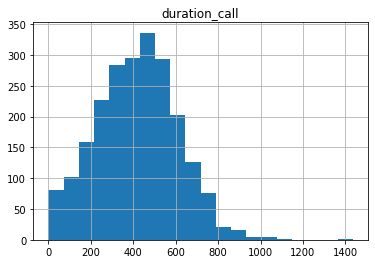

In [26]:
smart_data[['duration_call']].hist(bins=20)

Распределение гистограммы можно назвать нормальным, видно, что абсолютное большинство абонентов тарифа smart используют от 350 до 550 минут звонков в месяц.

---------------------------------------------------

In [27]:

ultra_data[['duration_call']].describe()

,duration_call
count,985.000000
mean,526.623350
std,317.606098
min,0.000000
25%,284.000000
50%,518.000000
75%,752.000000
max,1673.000000


в среднем пользователь ultra обычно тратит за месяц 526 мин. (среднее)

ст.откл. = 317 мин

In [28]:
#посчитаем дисперсию
variance_ultra = np.var(ultra_data[['duration_call']])
variance_ultra

duration_call    100771.223617
dtype: float64

In [29]:
# и мат.ожидание 
expectation_ultra = np.sqrt(variance_ultra)
expectation_ultra

duration_call    317.444836
dtype: float64

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10e9ec6cd0>]],
      dtype=object)

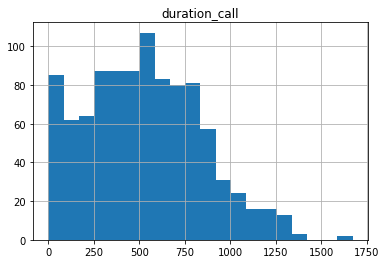

In [30]:
ultra_data[['duration_call']].hist(bins=20)

Распределение гистограммы можно назвать нормальным, видно, что абсолютное большинство абонентов тарифа ultra используют от 400 до 550 минут звонков в месяц.

 **Пользователи smart тарифа используют не сильно меньшее минут в месяц, чем пользователи ultra. Скорее всего, пользователи ultra выбирают этот тариф не из-за количества минут, а по другим причинам. Однако, распределение на гистограммах неодинаковое и можно заметить, что есть ряд пользователей ultra, которые всё-таки используют большее количество минут по назначению, хотя никто и не достигает лимита в 3000 минут.**

#### Проанализируем сообщения

In [31]:
smart_data[['count_messages']].describe()

,count_messages
count,2229.000000
mean,33.384029
std,28.227876
min,0.000000
25%,10.000000
50%,28.000000
75%,51.000000
max,143.000000


в среднем пользователь smart обычно отправляют за месяц 33 сообщений (среднее)

ст.откл. = 28 сообщений

In [32]:
ultra_data[['count_messages']].describe()

,count_messages
count,985.000000
mean,49.363452
std,47.804457
min,0.000000
25%,6.000000
50%,38.000000
75%,79.000000
max,224.000000


в среднем пользователь ultra обычно отправляют за месяц 49 сообщений (среднее)

ст.откл. = 47 сообщений

In [33]:
#посчитаем дисперсию smart
variance_smart = np.var(smart_data[['count_messages']])
variance_smart


count_messages    796.455483
dtype: float64

In [34]:
# и мат.ожидание smart
expectation_smart = np.sqrt(variance_smart)
expectation_smart

count_messages    28.221543
dtype: float64

In [35]:
#посчитаем дисперсию ultra
variance_ultra = np.var(ultra_data[['count_messages']])
variance_ultra

count_messages    2282.946075
dtype: float64

In [36]:
# и мат.ожидание ultra
expectation_ultra = np.sqrt(variance_ultra)
expectation_ultra

count_messages    47.780185
dtype: float64

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10e7d99a10>]],
      dtype=object)

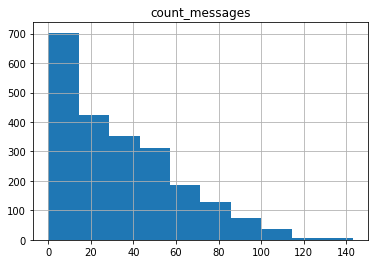

In [37]:
smart_data[['count_messages']].hist()

Гистограмма скошена вправо (среднее больше медианы). Получается, хотя большинство пользователей используют сообщения в рамках лимита - 50 - всё же есть те, кто значительно превышает лимит, тем самым принося выручку компании.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10e7d7b910>]],
      dtype=object)

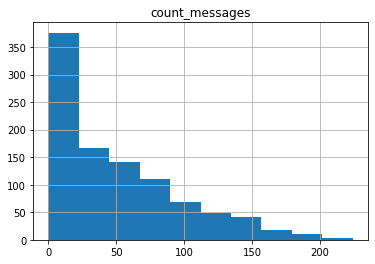

In [38]:
ultra_data[['count_messages']].hist()

Гистограмма здесь также скошена вправо

**Кажется, основная масса пользователей ultra использует еще меньше сообщений, чем в smart. Однако, опять-таки, есть и те, кто отправляет 100 и больше сообщений. Но лимита в 1000 сообщений не достигает никто.**

#### Проанализируем сипользование интернета

In [39]:
smart_data[['gb_used']].describe()

,gb_used
count,2229.000000
mean,16.328847
std,5.747061
min,0.000000
25%,13.000000
50%,17.000000
75%,20.000000
max,38.000000


в среднем пользователь smart обычно тратит за месяц 16 gd (среднее)

ст.откл. = 5 gb

In [40]:
ultra_data[['gb_used']].describe()

,gb_used
count,985.000000
mean,19.494416
std,9.853511
min,0.000000
25%,12.000000
50%,19.000000
75%,27.000000
max,49.000000


в среднем пользователь ultra обычно тратит за месяц 19 gd (среднее)

ст.откл. = 10 gb

In [41]:
#посчитаем дисперсию smart
variance_smart = np.var(smart_data[['gb_used']])
variance_smart

gb_used    33.013887
dtype: float64

In [42]:
# и мат.ожидание smart
expectation_smart = np.sqrt(variance_smart)
expectation_smart

gb_used    5.745771
dtype: float64

In [43]:
#посчитаем дисперсию ultra
variance_ultra = np.var(ultra_data[['gb_used']])
variance_ultra

gb_used    96.993116
dtype: float64

In [44]:
# и мат.ожидание ultra
expectation_ultra = np.sqrt(variance_ultra)
expectation_ultra

gb_used    9.848508
dtype: float64

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10e7cc0550>]],
      dtype=object)

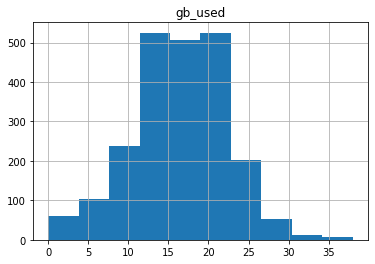

In [45]:
smart_data[['gb_used']].hist()

Распределение нормальное, видим, что часть пользователей придерживается крайних значений лимита (15gb), однако вторая часть пользователей докупает недостающий трафик. Посмотрим на данные по второму тарифу.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10e7c20550>]],
      dtype=object)

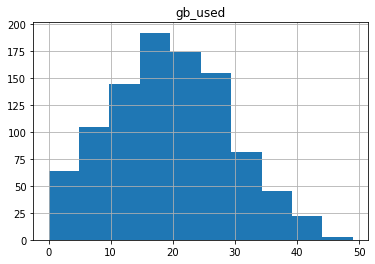

In [46]:
ultra_data[['gb_used']].hist()

Здесь становится понятно, почему основная масса пользователей тарифа ultra выбирает именно его. Они используют намного больше трафика, чем пользователи smart.

**Вывод:**

**Пользователи smart тарифа используют чуть меньшее количество минут звонков и сообщений в месяц, чем пользователи ultra. Лимита на звонки и минуты в ultra в среднем не достигает никто. При этом интернетом пользователи ultra пользуются гораздо активнее. Скорее всего, пользователи ultra выбирают этот тариф из-за большего интернет-трафика.**

**Отметим, что пользователи тарифа smart чаще переплачивают за недостающие менуты, сообщения и gb**

### Проверим гипотезы

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем нулевую и альтернативную гипотезы. Нулевую гипотезу будем формулировать так, чтобы использовать знак равенства. Альтернативную гипотезу сформулируем оттакливаясь от нулевой гипотезы.

* H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна
* H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна

In [47]:
#зададим критический уровень статистической значимости
alpha = .05

In [48]:
results = st.ttest_ind(
    smart_data['total_cost'],
    ultra_data['total_cost']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя тарифа smart -', smart_data['total_cost'].mean().round(2))
print('Средняя выручка в месяц с пользователя тарифа ultra -', ultra_data['total_cost'].mean().round(2))

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу

Средняя выручка в месяц с пользователя тарифа smart - 1289.97
Средняя выручка в месяц с пользователя тарифа ultra - 2070.15


**Отвергаем первую гипотезу. Всё же между выручкой есть разница. По среднему значению видим, что выручка с пользователей тарифа ultra больше.**

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем нулевую и альтернативную гипотезы:

* H₀ - средняя выручка пользователей из Москвы и остальных регионов равна
* H₁ - средняя выручка пользователей из Москвы и остальных регионов не равна

In [49]:
# Отсортируем сводный DataFrame
from_moscow = total_data.query('city == "Москва"')
not_from_moscow = total_data.query('city != "Москва"')

In [50]:
results = st.ttest_ind(
    from_moscow['total_cost'],
    not_from_moscow['total_cost']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя из Москвы', from_moscow['total_cost'].mean().round(2))
print('Средняя выручка в месяц с пользователя не из Москвы', not_from_moscow['total_cost'].mean().round(2))

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу

Средняя выручка в месяц с пользователя из Москвы 1546.71
Средняя выручка в месяц с пользователя не из Москвы 1524.94


**Вторую гипотезу отвергнуть не удалось: выручка с пользователей-москвичей и пользователей из других регионов почти равнозначна.**

### Общий вывод

Тариф ultra приносит компании больше выручку. Стоит сфокусироваться на его продвижении повсеместно - в Москве и других регионах.